# Run Inference

## Load Model

In [1]:
import torch
from model.model import CNN3Layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load the model
model = CNN3Layer().to(device)
model.load_state_dict(torch.load('detect_ship_model.pth'))

model.eval()  # Set the model to evaluation mode

Using device: cuda


C:\Users\thanh\AppData\Local\Temp\ipykernel_10504\2791035411.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('detect_ship_model.pth'))


CNN3Layer(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

### Image Loading and Conversion

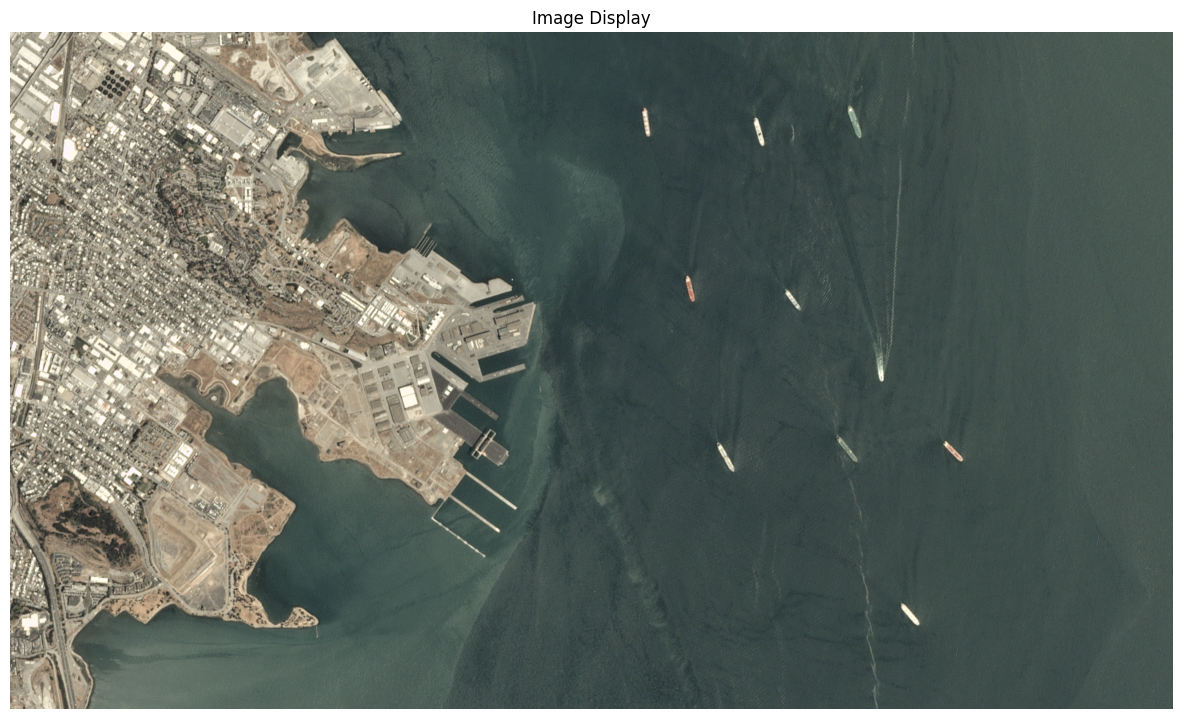

Tensor shape: torch.Size([3, 1577, 2709])


In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('C:\\Users\\thanh\\Downloads\\archive\\scenes\\scenes\\sfbay_3.png')

# Convert the image into NumPy array and PyTorch tensor
picture_array = np.array(image).astype('uint8')  # Convert image to NumPy array
picture_tensor = torch.tensor(picture_array).permute(2, 0, 1)  # Convert to PyTorch Tensor [C, H, W]

# Extract dimensions of the image
n_spectrum = picture_tensor.shape[0]  # Number of color channels (C = 3 for RGB)
height, width = picture_tensor.shape[1], picture_tensor.shape[2]  # Height and Width of the image

# Visualize the image using Matplotlib
plt.figure(figsize=(15, 10))  # Set the figure size

plt.subplot(1, 1, 1)  # Single plot
plt.imshow(picture_tensor.permute(1, 2, 0))  # Convert [C, H, W] -> [H, W, C] for visualization
plt.title("Image Display")  # Set the title
plt.axis("off")  # Turn off axes for better visualization

plt.show()

# Display the shape of the tensor
print(f"Tensor shape: {picture_tensor.shape}")  # Print the shape [C, H, W]

### Helper Functions for Image Processing and Visualization

In [11]:
# 1. Cutting function: Extracts an 80x80 region
def cutting(x, y, picture_tensor):
    """
    Extract an 80x80 region from the original tensor, normalize, and add batch dimension.
    """
    # Step 1: Extract the region [C, 80, 80]
    area_study = picture_tensor[:, y:y+80, x:x+80]

    # Step 2: Retain only the first 3 channels (RGB) if more exist
    if area_study.shape[0] > 3:
        area_study = area_study[:3, :, :]

    # Step 3: Normalize pixel values to [0, 1]
    area_study = area_study.float() / 255.0

    # Step 4: Add batch dimension [1, C, 80, 80]
    area_study = area_study.unsqueeze(0)

    return area_study

# 2. Proximity check function
def not_near(x, y, s, coordinates):
    """
    Check if the new detection is sufficiently far from existing detections.
    """
    for e in coordinates:
        if (x-s < e[0][0] < x+s) and (y-s < e[0][1] < y+s):
            return False  # Detection is too close
    return True

# 3. Visualization function
def show_ship(x, y, picture_tensor, thickness=5):
    """
    Draw a border around an 80x80 region to indicate a detected ship.
    """
    # Step 1: Draw borders on the top and bottom edges
    picture_tensor[:, y:y+thickness, x:x+80] = -1  # Top border
    picture_tensor[:, y+80:y+80+thickness, x:x+80] = -1  # Bottom border

    # Step 2: Draw borders on the left and right edges
    picture_tensor[:, y:y+80, x:x+thickness] = -1  # Left border
    picture_tensor[:, y:y+80, x+80:x+80+thickness] = -1  # Right border

    return picture_tensor

### Sliding Window Detection for Ships in Satellite Images

X: 760, Y: 50, Confidence: 0.9317


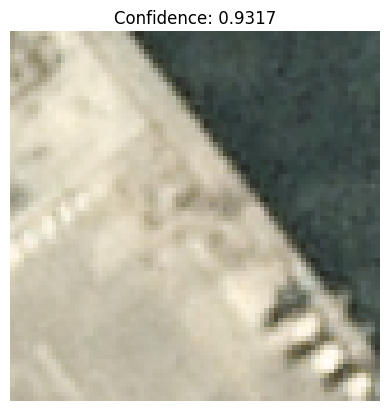

X: 1920, Y: 160, Confidence: 0.9946


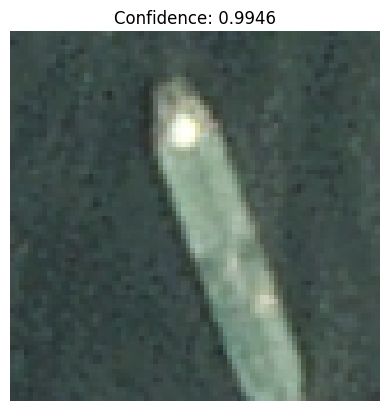

X: 1440, Y: 170, Confidence: 1.0000


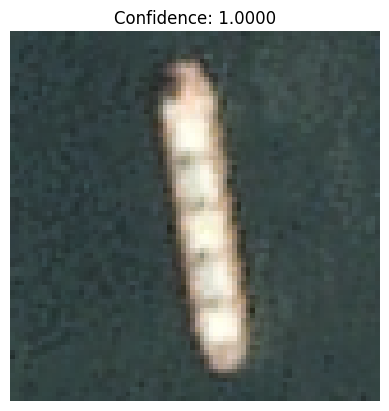

X: 1700, Y: 190, Confidence: 1.0000


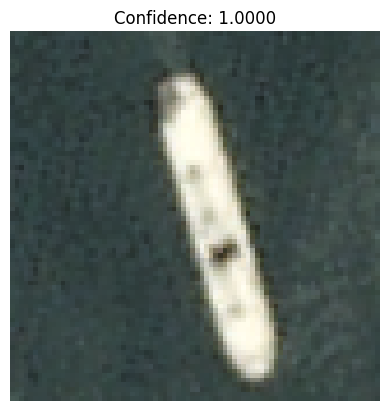

X: 840, Y: 240, Confidence: 0.9999


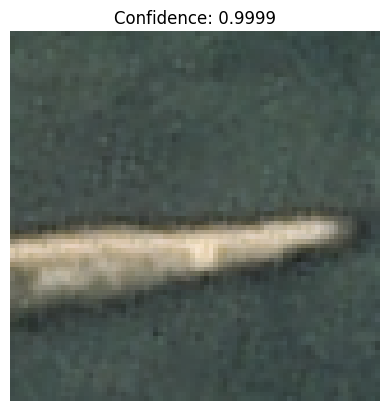

X: 730, Y: 250, Confidence: 0.9991


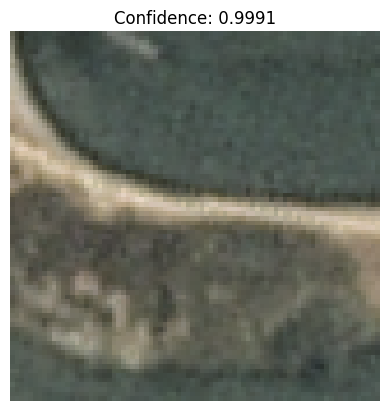

X: 1540, Y: 550, Confidence: 1.0000


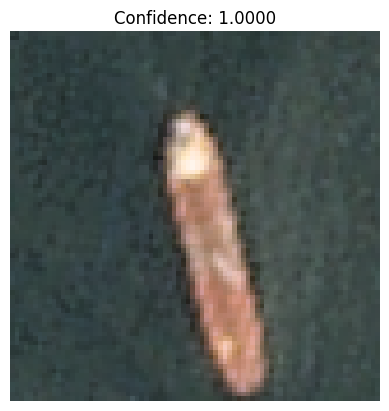

X: 1780, Y: 580, Confidence: 1.0000


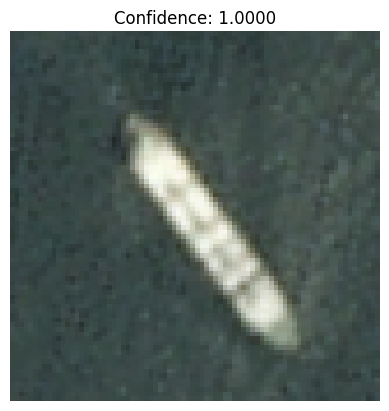

X: 1990, Y: 740, Confidence: 0.9987


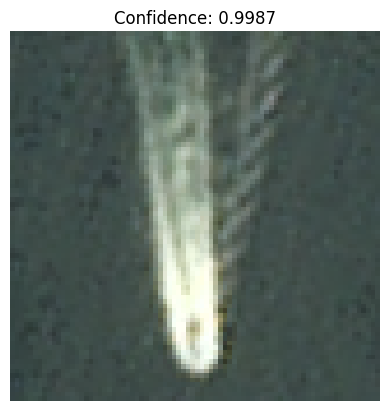

X: 1110, Y: 750, Confidence: 1.0000


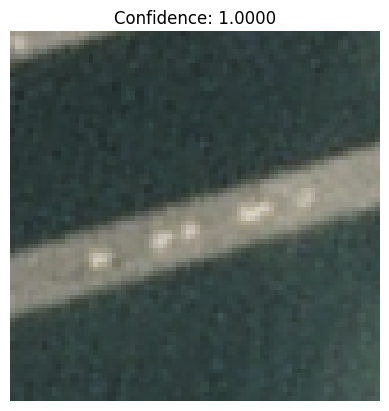

X: 990, Y: 910, Confidence: 0.9977


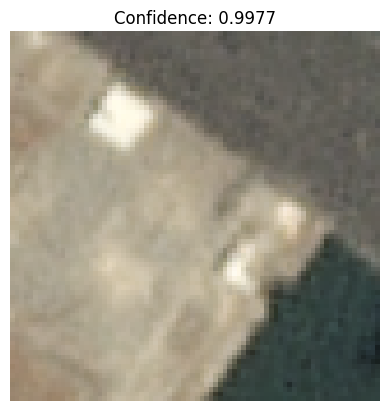

X: 1910, Y: 930, Confidence: 1.0000


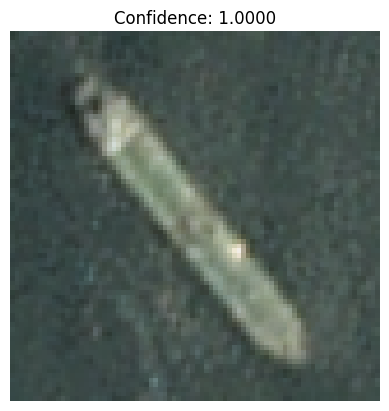

X: 2160, Y: 930, Confidence: 1.0000


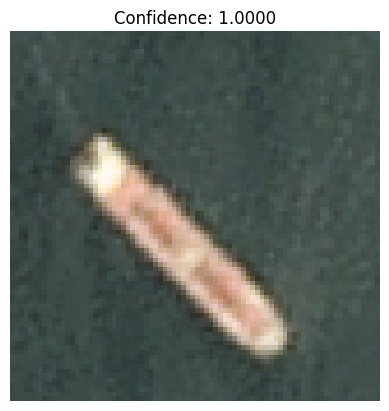

X: 1620, Y: 940, Confidence: 1.0000


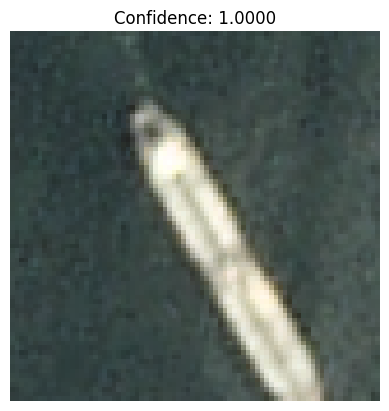

X: 1050, Y: 1000, Confidence: 0.9964


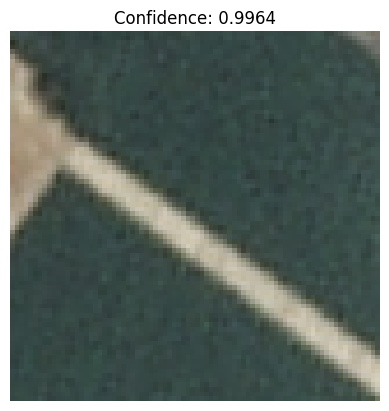

X: 970, Y: 1100, Confidence: 0.9991


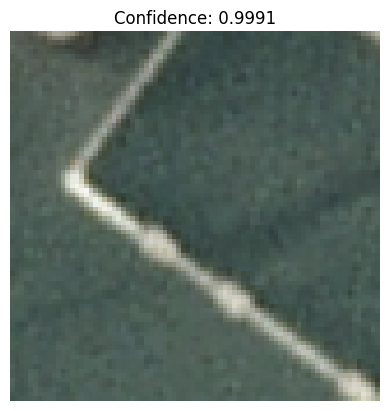

X: 1070, Y: 1100, Confidence: 1.0000


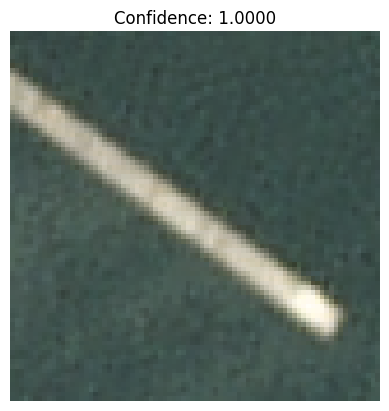

X: 2050, Y: 1310, Confidence: 0.9938


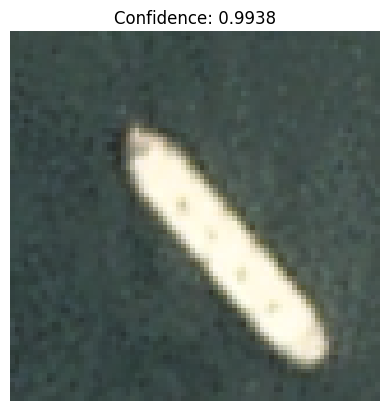

X: 580, Y: 1340, Confidence: 1.0000


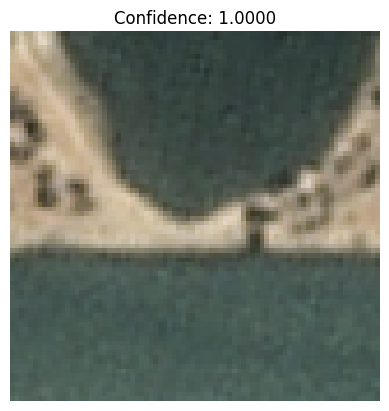

In [12]:
step = 10  # Sliding window step size
coordinates = []  # List to store detected ship coordinates and confidence scores

# Set the model to evaluation mode
model.eval()

# Sliding window over the entire image
with torch.no_grad():  # Disable gradient computation
    for y in range(0, height - 80, step):  # Slide vertically
        for x in range(0, width - 80, step):  # Slide horizontally
            # Step 1: Extract an 80x80 patch
            area = cutting(x, y, picture_tensor)  # Function to crop the area: [1, C, 80, 80]
            area = area.to(device)  # Move the cropped patch to GPU if available
            
            # Step 2: Predict the class probabilities
            result = torch.softmax(model(area), dim=1)  # Compute probabilities
            confidence = result[0][1].item()  # Probability of class "1" (ship)

            # Step 3: Check confidence threshold and proximity to other detections
            if confidence > 0.90 and not_near(x, y, 88, coordinates):  # Threshold = 0.90
                coordinates.append([[x, y], confidence])  # Store coordinates and confidence
                print(f"X: {x}, Y: {y}, Confidence: {confidence:.4f}")  # Print detection
                
                # Step 4: Visualize the detected patch
                plt.imshow(area[0].cpu().permute(1, 2, 0))  # Convert [C, H, W] -> [H, W, C]
                plt.title(f"Confidence: {confidence:.4f}")  # Title with confidence score
                plt.axis("off")  # Remove axes
                plt.show()

### Displaying Detected Regions on the Image 

Tensor shape after transpose: (1577, 2709, 3)


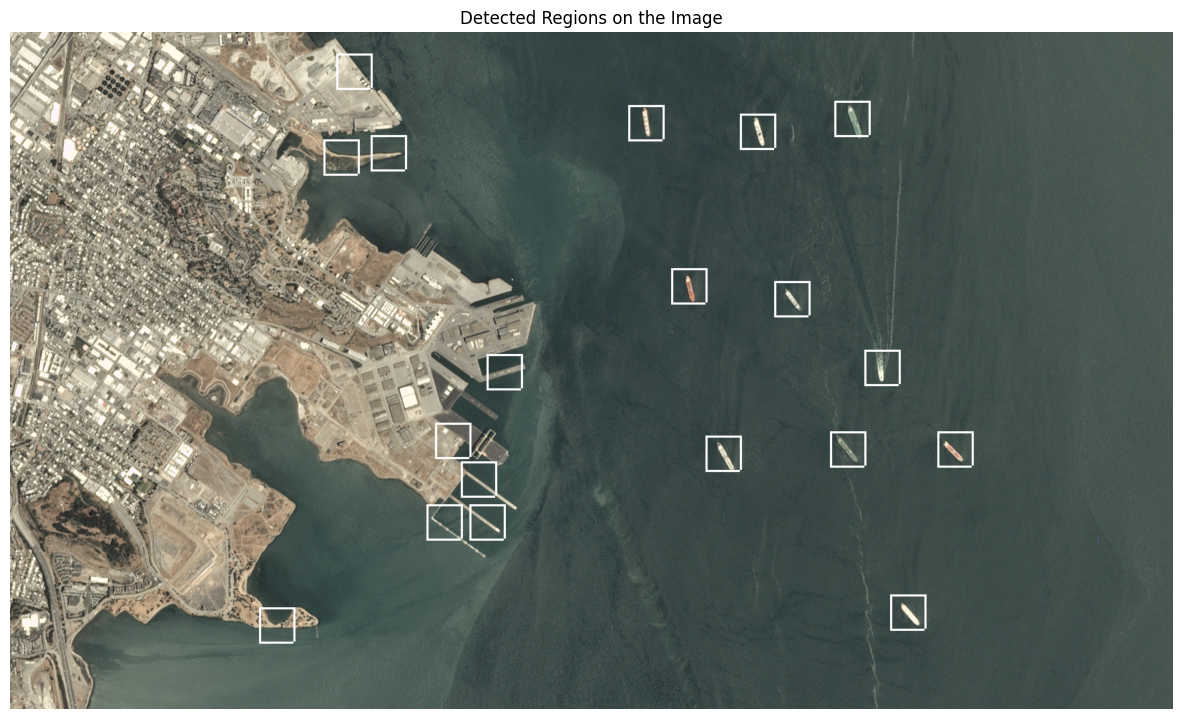

In [13]:
# Draw bounding boxes around all detected regions
for e in coordinates:
    x, y = e[0][0], e[0][1]  # Extract the top-left corner coordinates
    show_ship(x, y, picture_tensor, thickness=5)  # Draw the bounding box

# Convert the tensor to NumPy format for visualization
picture_tensor_display = picture_tensor.permute(1, 2, 0).cpu().numpy()  # Convert [C, H, W] -> [H, W, C]

# Verify the dimensions of the tensor
print(f"Tensor shape after transpose: {picture_tensor_display.shape}")  # Output: [Height, Width, Channels]

# Display the resulting image with bounding boxes
plt.figure(figsize=(15, 10))  # Set the figure size
plt.imshow(picture_tensor_display)  # Display the image
plt.title("Detected Regions on the Image")  # Add a title
plt.axis("off")  # Turn off axes for cleaner visualization
plt.show()